# 开发 AI 应用

未来，AI 算法在日常生活中的应用将越来越广泛。例如，你可能想要在智能手机应用中包含图像分类器。为此，在整个应用架构中，你将使用一个用成百上千个图像训练过的深度学习模型。未来的软件开发很大一部分将是使用这些模型作为应用的常用部分。

在此项目中，你将训练一个图像分类器来识别不同的花卉品种。可以想象有这么一款手机应用，当你对着花卉拍摄时，它能够告诉你这朵花的名称。在实际操作中，你会训练此分类器，然后导出它以用在你的应用中。我们将使用[此数据集](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)，其中包含 102 个花卉类别。你可以在下面查看几个示例。 

<img src='assets/Flowers.png' width=500px>

该项目分为多个步骤：

* 加载和预处理图像数据集
* 用数据集训练图像分类器
* 使用训练的分类器预测图像内容

我们将指导你完成每一步，你将用 Python 实现这些步骤。建议在基本完成提示代码的情况下再开启GPU调试。

完成此项目后，你将拥有一个可以用任何带标签图像的数据集进行训练的应用。你的网络将学习花卉，并成为一个命令行应用。但是，你对新技能的应用取决于你的想象力和构建数据集的精力。例如，想象有一款应用能够拍摄汽车，告诉你汽车的制造商和型号，然后查询关于该汽车的信息。构建你自己的数据集并开发一款新型应用吧。

首先，导入你所需的软件包。建议在代码开头导入所有软件包。当你创建此 notebook 时，如果发现你需要导入某个软件包，确保在开头导入该软件包。

In [48]:
# Imports here
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from collections import OrderedDict
import json

## 加载数据

在此项目中，你将使用 `torchvision` 加载数据（[文档](http://pytorch.org/docs/master/torchvision/transforms.html#)）。数据应该和此 notebook 一起包含在内，否则你可以[在此处下载数据](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz)。数据集分成了三部分：训练集、验证集和测试集。对于训练集，你需要变换数据，例如随机缩放、剪裁和翻转。这样有助于网络泛化，并带来更好的效果。你还需要确保将输入数据的大小调整为 224x224 像素，因为预训练的网络需要这么做。

验证集和测试集用于衡量模型对尚未见过的数据的预测效果。对此步骤，你不需要进行任何缩放或旋转变换，但是需要将图像剪裁到合适的大小。

对于所有三个数据集，你都需要将均值和标准差标准化到网络期望的结果。均值为 `[0.485, 0.456, 0.406]`，标准差为 `[0.229, 0.224, 0.225]`。这样使得每个颜色通道的值位于 -1 到 1 之间，而不是 0 到 1 之间。

In [49]:
train_dir = '/data/flowers/train'
valid_dir = '/data/flowers/valid'
test_dir = '/data/flowers/test'

提示：
- train数据集的transforms需要进行裁剪，均值和标准化，并且要对图像进行随机缩放、剪裁和翻转等等，有助于网络泛化，test和valid数据集的transforms只需要裁剪到合适的大小并进行均值和标准化。综上所述，valid数据集和test数据集使用同一个transform即可
- 注意需要先resize图片，再crop，否则对于较大图片可能crop不到花朵部分
- datasets设置时注意参数的变化（目录的不同）
- loader设置时，train的loader的参数注意设置：shuffle = True，来增加训练图像时的随机性。

In [50]:
#TODO: 定义transforms
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
# TODO: 使用dir路径定义datasets，注意配置相对应的transforms
train_datasets = datasets.ImageFolder(train_dir,transform=train_transforms)
valid_datasets = datasets.ImageFolder(valid_dir,transform=test_transforms)
test_datasets = datasets.ImageFolder(test_dir,transform=test_transforms)
# TODO: 使用datasets定义dataloaders
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_datasets, batch_size=30)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=20)


### 标签映射

你还需要加载从类别标签到类别名称的映射。你可以在文件 `cat_to_name.json` 中找到此映射。它是一个 JSON 对象，可以使用 [`json` 模块](https://docs.python.org/2/library/json.html)读取它。这样可以获得一个从整数编码的类别到实际花卉名称的映射字典。

In [51]:

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# 构建和训练分类器

数据准备好后，就开始构建和训练分类器了。和往常一样，你应该使用 `torchvision.models` 中的某个预训练模型获取图像特征。使用这些特征构建和训练新的前馈分类器。

这部分将由你来完成。如果你想与他人讨论这部分，欢迎与你的同学讨论！你还可以在论坛上提问或在工作时间内咨询我们的课程经理和助教导师。

请参阅[审阅标准](https://review.udacity.com/#!/rubrics/1663/view)，了解如何成功地完成此部分。你需要执行以下操作：

* 加载[预训练的网络](https://pytorch.org/docs/stable/torchvision/models.html)
* 使用 ReLU 激活函数和丢弃定义新的未训练前馈网络作为分类器
* 使用反向传播训练分类器层，并使用预训练的网络获取特征
* 跟踪验证集的损失和准确率，以确定最佳超参数

按照提示逐步完成项目，检查确保每部分都达到预期效果，然后再完成下个部分。你可能会发现，当你实现每部分时，可能需要回去修改之前的代码，这很正常！

训练时，确保仅更新前馈网络的权重。如果一切构建正确的话，验证准确率应该能够超过 70%。确保尝试不同的超参数（学习速率、分类器中的单元、周期等），寻找最佳模型。保存这些超参数并用作项目下个部分的默认值。

下面让我们开始吧！

提示1：
- 挑选一个模型，加载预训练模型（既然是*预*训练的模型，那么注意参数pretrained应为True）

In [52]:
# TODO
model = models.densenet121(pretrained=True)
model.cuda()

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

提示2：
- [冻结模型梯度权重](https://pytorch.org/docs/stable/notes/autograd.html?highlight=param%20requires_grad)，设置每一层的param.requires_grad标志

In [53]:
# TODO
for param in model.parameters():
    param.requires_grad = False


提示3：
- 增加全连接层，dropout层，以及Relu激活函数
- 修改classifier层的主要目的是为了适应我们的分类要求，即最终的输出层要输出102种花卉分类（即要有一层全连接层输出为102，**不要**在输出层后加dropout）
- 全连接层后使用[LogSoftmax](https://pytorch.org/docs/stable/nn.html?highlight=nllloss#torch.nn.LogSoftmax)或者[softmax](https://pytorch.org/docs/stable/nn.html?highlight=nllloss#torch.nn.softmax)，来得出每种花的概率

In [54]:
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('drop1',nn.Dropout(0.5)),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(500, 128)),
                          ('drop2', nn.Dropout(0.5)),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(128,102)), 
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    

model.classifier = classifier
# 将模型转入gpu
model.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

提示4：
- 设置[损失函数](https://pytorch.org/docs/stable/nn.html?highlight=nllloss#torch.nn.NLLLoss)
- 设置[优化器](https://pytorch.org/docs/stable/optim.html)

In [55]:
# TODO
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

提示5：
- 分别写成两个函数用于训练模型和测试模型(课程中写到了一个代码中)，便于调试代码，以及增加程序的可读性
- 因为模型已经转入gpu，这里注意需要将数据也转入gpu
- 注意输出训练测试过程，把控模型是否欠拟合或者过拟合
- 模型训练时要model.train()，模型测试时要model.eval()，让模型进入训练或者测试的模式中

In [56]:
# TODO: 训练网络，需要有loss和accuracy打印输出
def train(model, loader):
    model.train()
    train_loss = 0
    times = 0
    for ii,(inputs,labels) in enumerate(loader):
        inputs,labels = Variable(inputs),Variable(labels)
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        times += 1
        train_loss += loss.item()
        if times % 5 == 0:
            avg_loss = float(train_loss / 5)
            print(f"loss is: {avg_loss}")
            train_loss = 0

In [57]:
# TODO:测试网络，使用验证集或者测试集，训练模型时使用验证集，测试模型最终结果使用测试集
# 需要有loss和accuracy打印输出
def test(model, loader):
    model.eval()
    acc = 0
    total = 0
    with torch.no_grad():
        for ii,(inputs,labels) in enumerate(loader):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model.forward(inputs)
            total += labels.size(0)
            _,predicts = torch.max(outputs.data,1)
            acc += ((predicts == labels).sum().item())
        avg_acc = float(acc/total)*100
        print(f"acc is: {avg_acc}")

In [58]:
epoch = 10#TODO 修改epoch次数
for _ in range(1, epoch):
    train(model, train_loader)
    test(model, valid_loader)

loss is: 4.6511890411376955
loss is: 4.630600929260254
loss is: 4.601111030578613
loss is: 4.572874927520752
loss is: 4.5428032875061035
loss is: 4.5006529808044435
loss is: 4.496191215515137
loss is: 4.500609397888184
loss is: 4.474421882629395
loss is: 4.444978809356689
loss is: 4.356191253662109
loss is: 4.401125431060791
loss is: 4.259538555145264
loss is: 4.307481288909912
loss is: 4.302001094818115
loss is: 4.179360485076904
loss is: 4.24769697189331
loss is: 4.200662994384766
loss is: 4.2025152206420895
loss is: 4.025714302062989
acc is: 17.48166259168704
loss is: 4.000322246551514
loss is: 3.8857728481292724
loss is: 3.7934287548065186
loss is: 3.7420089721679686
loss is: 3.632741403579712
loss is: 3.7188040256500243
loss is: 3.677506446838379
loss is: 3.5801863193511965
loss is: 3.545165538787842
loss is: 3.5166927337646485
loss is: 3.354386806488037
loss is: 3.5152113914489744
loss is: 3.2487669467926024
loss is: 3.384453821182251
loss is: 3.296240234375
loss is: 3.1096575260

## 测试网络

建议使用网络在训练或验证过程中从未见过的测试数据测试训练的网络。这样，可以很好地判断模型预测全新图像的效果。用网络预测测试图像，并测量准确率，就像验证过程一样。如果模型训练良好的话，你应该能够达到大约 70% 的准确率。

In [65]:
# TODO: 在测试集上进行测试，需要输出结果
test(model, test_loader)

acc is: 82.90598290598291


## 保存检查点

训练好网络后，[保存模型](https://pytorch.org/docs/stable/torch.html?highlight=torch%20save#torch.save)，以便稍后加载它并进行预测。你可能还需要保存其他内容，例如从类别到索引的映射，索引是从某个图像数据集中获取的：`image_datasets['train'].class_to_idx`。你可以将其作为属性附加到模型上，这样稍后推理会更轻松。

提示：
- 创建checkpoint字典，字典中最少需要包含模型model相关和题目中要求的image_datasets['train'].class_to_idx
- 使用torch.save保存checkpoint字典

In [60]:
# TODO: Save the checkpoint 

checkpoint = {'input_size':1024,'output_size':102,
               'hidden_layers':[500,128],
             'state_dict': model.state_dict(),
             'class_to_idx':train_datasets.class_to_idx}
torch.save(checkpoint, 'checkpoint.pth')

## 加载检查点

此刻，建议写一个可以加载检查点并重新构建模型的函数。这样的话，你可以回到此项目并继续完善它，而不用重新训练网络。

提示：
- 加载”保存检查点“所保存的文件，用于恢复模型
- 注意torch的save会原模原样保存你需要保存的数据，因为你保存的是字典，从文件加载出来的就是一个字典类型的数据，按照字典方式操作即可。比如
```
#保存：
dict1 = {"A" : 1, "B": 2}
torch.save(dict1, filepath)
#加载：
checkpoint = torch.load(filepath)
A = checkpoint["A"]
B = checkpoint["B"]
```
- image_datasets['train'].class_to_idx，这个是指花朵本身对应的文件夹名称（数字）到模型预测出来的名称（数字）的一个对应关系，是一个字典形式，为了后面方便查询（通过预测出来的名称来得到真正的花朵所在文件夹的名称），这里需要将class_to_idx这个字典键key和值value颠倒过来
- 题目要求是函数，所以函数最终需要返回可以用于预测的模型以及颠倒后的class_to_idx

In [61]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    model = models.densenet121(pretrained=True)
    checkpoint = torch.load(filepath)
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(checkpoint['input_size'], checkpoint['hidden_layers'][0])),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(checkpoint['hidden_layers'][0], checkpoint['hidden_layers'][1])),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(checkpoint['hidden_layers'][1],checkpoint['output_size'])), 
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    model.classifier = classifier
    model.load_state_dict(checkpoint['state_dict'])
    return model,checkpoint['class_to_idx']

In [64]:
model, class_to_idx = load_checkpoint('checkpoint.pth')
class_to_idx = dict(zip(class_to_idx.values(), class_to_idx.keys()))
print(class_to_idx)
model.cuda()
model.eval()
model

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


{0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: '90', 93: '91', 94: '92', 95: '93', 96: '94', 97: '95', 98: '96', 99: '97', 100: '98', 101:

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

# 类别推理

首先，你需要处理输入图像，使其可以用于你的网络。

## 图像处理

你需要使用 `PIL` 加载图像（[文档](https://pillow.readthedocs.io/en/latest/reference/Image.html)）。建议写一个函数来处理图像，使图像可以作为模型的输入。该函数应该按照训练的相同方式处理图像。

首先，调整图像大小，使最小的边为 256 像素，并保持宽高比。为此，可以使用 [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) 或 [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) 方法。然后，你需要从图像的中心裁剪出 224x224 的部分。

图像的颜色通道通常编码为整数 0-255，但是该模型要求值为浮点数 0-1。你需要变换值。使用 Numpy 数组最简单，你可以从 PIL 图像中获取，例如 `np_image = np.array(pil_image)`。

和之前一样，网络要求图像按照特定的方式标准化。均值应标准化为 `[0.485, 0.456, 0.406]`，标准差应标准化为 `[0.229, 0.224, 0.225]`。你需要用每个颜色通道减去均值，然后除以标准差。

最后，PyTorch 要求颜色通道为第一个维度，但是在 PIL 图像和 Numpy 数组中是第三个维度。你可以使用 [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html)对维度重新排序。颜色通道必须是第一个维度，并保持另外两个维度的顺序。

提示：
- 按照上述要求来写即可，特别提示维度排序：np_image.transpose((2, 0, 1))，这个样子是指将第三个维度（颜色）换到了第一个维度上，其他两个维度保持顺序
- 另外要注意，np和PIL的很多操作都是在返回值中进行修改，而不会对原数据进行修改，务必要进行赋值操作
- 运行下面的测试，如果出现下面的图，则编写正确：
<img src='assets/1_flower.png'>

In [66]:
from PIL import Image
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    im = Image.open(image)
    im.thumbnail((im.size[0]/im.size[1]*256,256))
    half_the_width = im.size[0] / 2
    half_the_height = im.size[1] / 2
    img = im.crop(
        (
            half_the_width - 112,
            half_the_height - 112,
            half_the_width + 112,
            half_the_height + 112
        )
    )
    
    np_image = np.array(img)
    np_image = np_image / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    norm = (np_image - mean) / std
    np_image = norm.transpose((2, 0, 1))
    new_img = torch.from_numpy(np_image)
    return new_img


要检查你的项目，可以使用以下函数来转换 PyTorch 张量并将其显示在  notebook 中。如果 `process_image` 函数可行，用该函数运行输出应该会返回原始图像（但是剪裁掉的部分除外）。

In [67]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

测试一下，跟提示中出现同样的花朵后才可进行下一道题：

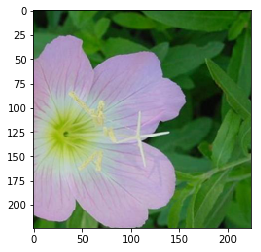

In [68]:
img_tensor = process_image(train_dir+"/1/image_06735.jpg")
imshow(img_tensor)

## 类别预测

可以获得格式正确的图像后 

现在，使用训练的网络进行推理的函数。即你将向网络中传入一个图像路径，并预测图像中的花卉类别。这里实现了 `predict` 的函数，该函数会接受图像和模型，然后返回概率在前 $K$ 的类别及其概率。

要获得前 $K$ 个值，在张量中使用 [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk)。该函数会返回前 `k` 个概率和对应的类别索引。使用  `class_to_idx`将这些索引转换为实际类别标签，或者从用来加载数据的[ `ImageFolder`](https://pytorch.org/docs/master/torchvision/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder)进行转换。

In [ ]:
# 只是示例，不要运行，可以看出predict接收了图像的path以及加载出来的模型，返回了预测的种类索引和各个种类的概率
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']

In [71]:
# 不需要修改，运行即可
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    img_tensor = process_image(image_path)
    img_tensor.unsqueeze_(0)
    img_tensor = img_tensor.type(torch.cuda.FloatTensor)
    output = model(Variable(img_tensor.cuda(), volatile=True))
    ps = torch.exp(output)
    probs, index = ps.topk(topk)
    print(probs)
    print(index)
    probs = probs.cpu().detach().numpy().tolist()[0]
    index = index.cpu().detach().numpy().tolist()[0]
    index = [class_to_idx[i] for i in index]
    return probs, index

尝试调用预测一下，如果你的模型测出来概率最高的那个种类是1，即可进行下一道题的操作，否则你可能需要反复修改之前所有涉及到模型的问题，或者检查下加载检查点中的class_to_idx是否正确颠倒。

In [72]:
model.cuda()
probs, classes = predict(train_dir+"/1/image_06735.jpg", model)
print(probs)
print(classes)

tensor([[ 0.4505,  0.1424,  0.0860,  0.0635,  0.0520]], device='cuda:0')
tensor([[ 49,   0,  84,  13,  53]], device='cuda:0')
[0.4505045413970947, 0.14241357147693634, 0.0859593078494072, 0.06351864337921143, 0.05197347700595856]
['51', '1', '83', '19', '55']


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


## 检查运行状况

你已经可以使用训练的模型做出预测，现在检查模型的性能如何。即使测试准确率很高，始终有必要检查是否存在明显的错误。使用 `matplotlib` 将前 5 个类别的概率以及输入图像绘制为条形图，应该如下所示：

<img src='assets/inference_example.png' width=300px>

你可以使用 `cat_to_name.json` 文件（应该之前已经在 notebook 中加载该文件）将类别整数编码转换为实际花卉名称。要将 PyTorch 张量显示为图像，请使用定义如下的 `imshow` 函数。

提示：
- cat_to_name.json是文件夹的目录和真实花朵名称的对应关系，通过上一步predict得出的index对应到cat_to_name即可得到名称

In [73]:
# TODO: Display an image along with the top 5 classes
# 参数分别为测试花朵的路径，花朵种类的文件夹名称，模型，以及topk
import pandas as pd
import seaborn as sb
base_color = sb.color_palette()[0]
def show_result(path, classname, model, topk):
    probs, classes = predict(path,model,topk)
    print(probs)
    flowers = [cat_to_name[i] for i in classes]
    d = {'name':flowers,'probs': probs}
    top_flowers = pd.DataFrame(data=d)
    top_flowers.sort_values('probs', ascending=False)
    top_flowers.plot(kind='barh',y='probs',x='name', 
                     legend=False,color=base_color)

接下来测试一下，希望你绘制的图中，概率最高的花朵种类名称为trumpet creeper。

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


tensor([[ 0.3719,  0.0842,  0.0818,  0.0798,  0.0733]], device='cuda:0')
tensor([[  3,  21,  90,  56,  98]], device='cuda:0')
[0.3718686103820801, 0.08424408733844757, 0.08180424571037292, 0.07980090379714966, 0.07333474606275558]


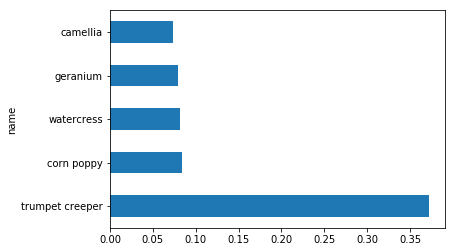

In [74]:
#直接运行
show_result(test_dir+"/101/image_07949.jpg", "101", model, 5)